In [1]:
import pandas as pd
import re
import numpy as np
import random
import collections
import codecs
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [70]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8738651721657568113
]


In [71]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [66]:
import tensorflow as tf

In [72]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Embedding, LSTM, concatenate, Flatten, Dropout

from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.initializers import Constant


In [73]:
df = pd.read_csv('training.csv')

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12977 entries, 0 to 12976
Data columns (total 6 columns):
essay_id         12977 non-null int64
essay_set        12977 non-null int64
essay            12977 non-null object
score            12977 non-null float64
type_of_essay    12977 non-null object
grade_level      12977 non-null int64
dtypes: float64(1), int64(3), object(2)
memory usage: 608.4+ KB


In [75]:
df.head(5)

,essay_id,essay_set,essay,score,type_of_essay,grade_level
0,1,1,"Dear local newspaper, I think effects computer...",0.6,persuasive / narrative / expository,8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.7,persuasive / narrative / expository,8
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.5,persuasive / narrative / expository,8
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.8,persuasive / narrative / expository,8
4,5,1,"Dear @LOCATION1, I know having computers has a...",0.6,persuasive / narrative / expository,8


### Replace original place holder for tokenizer 

In [76]:
p_caps = re.compile(r'@caps\d{0,2}', re.I)
p_city = re.compile(r'@city\d{0,2}', re.I)
p_date = re.compile(r'@date\d{0,2}', re.I)
p_dr = re.compile(r'@dr\d{0,2}', re.I)
p_location = re.compile(r'@location\d{0,2}', re.I)
p_money = re.compile(r'@money\d{0,2}', re.I)
p_month = re.compile(r'@month\d{0,2}', re.I)
p_num = re.compile(r'@num\d{0,2}', re.I)
p_organization = re.compile(r'@organization\d{0,2}', re.I)
p_percent = re.compile(r'@percent\d{0,2}', re.I)
p_person = re.compile(r'@person\d{0,2}', re.I)
p_state = re.compile(r'@state\d{0,2}', re.I)
p_time = re.compile(r'@time\d{0,2}', re.I)
p_email = re.compile(r'@email\d{0,2}', re.I)


def replace_label(e):
    p_caps = re.compile(r'@caps\d{0,2}', re.I)
    p_city = re.compile(r'@city\d{0,2}', re.I)
    p_date = re.compile(r'@date\d{0,2}', re.I)
    p_dr = re.compile(r'@dr\d{0,2}', re.I)
    p_location = re.compile(r'@location\d{0,2}', re.I)
    p_money = re.compile(r'@money\d{0,2}', re.I)
    p_month = re.compile(r'@month\d{0,2}', re.I)
    p_num = re.compile(r'@num\d{0,2}', re.I)
    p_organization = re.compile(r'@organization\d{0,2}', re.I)
    p_percent = re.compile(r'@percent\d{0,2}', re.I)
    p_person = re.compile(r'@person\d{0,2}', re.I)
    p_state = re.compile(r'@state\d{0,2}', re.I)
    p_time = re.compile(r'@time\d{0,2}', re.I)
    p_email = re.compile(r'@email\d{0,2}', re.I)


    text = e
    text = p_caps.sub('LABEL_CAPS', text)
    text = p_city.sub('LABEL_CITY', text)
    text = p_date.sub('LABEL_DATE', text)
    
    text = p_dr.sub('LABEL_DR', text)
    text = p_location.sub('LABEL_LOCATION', text)
    text = p_money.sub('LABEL_MONEY', text)
    text = p_month.sub('LABEL_MONTH', text)
    text = p_num.sub('LABEL_NUM', text)
    text = p_organization.sub('LABEL_ORGANIZATION', text)
    text = p_percent.sub('LABEL_PERCENT', text)
    text = p_person.sub('LABEL_PERSON', text)
    text = p_state.sub('LABEL_STATE', text)
    text = p_time.sub('LABEL_TIME', text)
    text = p_email.sub('LABEL_EMAIL', text)
    return text

In [77]:
df['essay_clean'] = df.essay.apply(replace_label)

In [78]:
df.head(5)

,essay_id,essay_set,essay,score,type_of_essay,grade_level,essay_clean
0,1,1,"Dear local newspaper, I think effects computer...",0.6,persuasive / narrative / expository,8,"Dear local newspaper, I think effects computer..."
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.7,persuasive / narrative / expository,8,"Dear LABEL_CAPS LABEL_CAPS, I believe that usi..."
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.5,persuasive / narrative / expository,8,"Dear, LABEL_CAPS LABEL_CAPS LABEL_CAPS More an..."
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.8,persuasive / narrative / expository,8,"Dear Local Newspaper, LABEL_CAPS I have found ..."
4,5,1,"Dear @LOCATION1, I know having computers has a...",0.6,persuasive / narrative / expository,8,"Dear LABEL_LOCATION, I know having computers h..."


### Check data quality
- the number of words in each essay
- the length of each essay

In [79]:
df['essay_clean'].str.count(' ').describe()

count    12977.000000
mean       226.045773
std        180.600845
min          1.000000
25%         98.000000
50%        164.000000
75%        315.000000
max       1118.000000
Name: essay_clean, dtype: float64

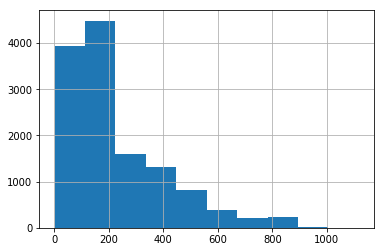

In [80]:
df['essay_clean'].str.count(' ').hist()

In [81]:
df[df['essay_clean'].str.count(' ')<10][:10]

,essay_id,essay_set,essay,score,type_of_essay,grade_level,essay_clean
356,359,1,"Being active has no limit, but technology does.",0.000000,persuasive / narrative / expository,8,"Being active has no limit, but technology does."
3998,6394,3,He race trying to get yosemitre for some rushi...,0.333333,source dependent responses,10,He race trying to get yosemitre for some rushi...
4556,6954,3,During this essay the author is talking about ...,0.333333,source dependent responses,10,During this essay the author is talking about ...
4825,7223,3,The features of the setting affected the cycli...,0.333333,source dependent responses,10,The features of the setting affected the cycli...
5532,9086,4,So she did not forget to take the test again.,0.333333,source dependent responses,10,So she did not forget to take the test again.
5930,9486,4,Saeng would return to her homeland.,0.000000,source dependent responses,10,Saeng would return to her homeland.
6199,9756,4,So she saying she will take the test next year.,0.333333,source dependent responses,10,So she saying she will take the test next year.
6313,9870,4,Reserved need to check keenly,1.000000,source dependent responses,10,Reserved need to check keenly
6444,10001,4,NO IMAGE,0.333333,source dependent responses,10,NO IMAGE
6574,10131,4,The Author concludes the with paragraph becaus...,0.000000,source dependent responses,10,The Author concludes the with paragraph becaus...


In [82]:
df['essay_clean'].str.len().describe()

count    12977.000000
mean      1235.375742
std        981.826316
min          8.000000
25%        532.000000
50%        911.000000
75%       1698.000000
max       6158.000000
Name: essay_clean, dtype: float64

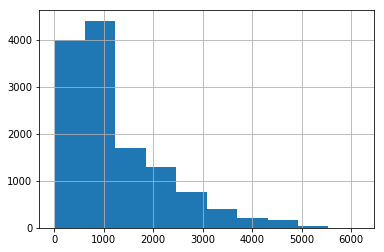

In [83]:
df['essay_clean'].str.len().hist()

In [84]:
df['essay_clean'].str.count(' ').describe()

count    12977.000000
mean       226.045773
std        180.600845
min          1.000000
25%         98.000000
50%        164.000000
75%        315.000000
max       1118.000000
Name: essay_clean, dtype: float64

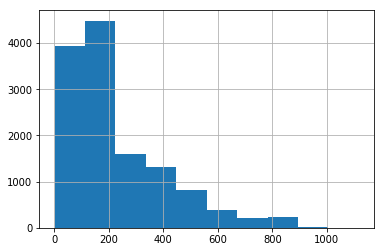

In [85]:
df['essay_clean'].str.count(' ').hist()

In [86]:
df[df['essay_clean'].str.count(' ') > 0].shape

(12977, 7)

In [87]:
df[(df['essay_clean'].str.count(' ')>20)].shape

(12858, 7)

In [88]:
df[(df['essay_clean'].str.count(' ')>20)]['essay_clean'].str.len().describe()


count    12858.000000
mean      1246.043786
std        980.044154
min        100.000000
25%        543.000000
50%        919.000000
75%       1709.000000
max       6158.000000
Name: essay_clean, dtype: float64

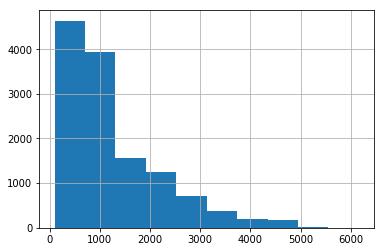

In [89]:
df[(df['essay_clean'].str.count(' ')>20)]['essay_clean'].str.len().hist()

# one hot encode for other features


In [90]:
df['type_of_essay_encode'] = df['type_of_essay'].str.replace(
    'persuasive / narrative  / expository', '0', case=True, regex=False)

df['type_of_essay_encode'] = df['type_of_essay_encode'].str.replace(
    'source dependent responses', '1', case=True, regex=False)

In [91]:
df['type_of_essay_encode'] = df['type_of_essay_encode'].astype(int)

In [92]:
df['type_of_essay_encode'].value_counts()

1    7102
0    5875
Name: type_of_essay_encode, dtype: int64

In [93]:
df['grade_level'].value_counts()

10    7820
8     3588
7     1569
Name: grade_level, dtype: int64

In [94]:
pd.get_dummies(df['grade_level'], prefix='level').head(3)

,level_7,level_8,level_10
0,0,1,0
1,0,1,0
2,0,1,0


# Separate text data

In [95]:
def save_essay_to_txt(row):
    with open('./data/essay/'+str(row['essay_id'])+'.txt', 'w') as f:
        f.write(row['essay_clean'])

In [96]:
df.apply(save_essay_to_txt, axis=1)
print('Finished.')

Finished.


In [97]:
df['filepath'] = './data/essay/'+df['essay_id'].astype(str)+'.txt'
df['filepath_tokenized'] = './data/essay_tokenized/'+df['essay_id'].astype(str)+'.txt'

In [98]:
with open("mapping.txt", "w") as f:
    for fp, fpt in zip(df['filepath'], df['filepath_tokenized']):
        f.write("{} \t {}\n".format(fp, fpt))

# Run tokenizer in terminal
``` bash
export CLASSPATH=~/stanford-corenlp/stanford-corenlp-full-2018-02-27/stanford-corenlp-3.9.1.jar

java edu.stanford.nlp.process.PTBTokenizer -ioFileList -preserveLines -options "normalizeParentheses=False,normalizeOtherBrackets=False" mapping.txt
```

# load tokenized files

In [99]:
def load_tokenized(row):
    with open(row['filepath_tokenized'], 'r') as f:
        return f.read()

In [100]:
df['essay_tokenized'] = df.apply(load_tokenized, axis=1)
print('Finished.')

Finished.


In [101]:
df.head(2)

,essay_id,essay_set,essay,score,type_of_essay,grade_level,essay_clean,type_of_essay_encode,filepath,filepath_tokenized,essay_tokenized
0,1,1,"Dear local newspaper, I think effects computer...",0.6,persuasive / narrative / expository,8,"Dear local newspaper, I think effects computer...",0,./data/essay/1.txt,./data/essay_tokenized/1.txt,"Dear local newspaper , I think effects compute..."
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.7,persuasive / narrative / expository,8,"Dear LABEL_CAPS LABEL_CAPS, I believe that usi...",0,./data/essay/2.txt,./data/essay_tokenized/2.txt,"Dear LABEL_CAPS LABEL_CAPS , I believe that us..."


# Prepare data

In [102]:
MAX_LEN = 400
VOCAB_SIZE = 5000

In [103]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=123)

In [104]:
# tk = Tokenizer(num_words=VOCAB_SIZE+1, oov_token='UNK')
tk = Tokenizer(num_words=VOCAB_SIZE)
# tk = Tokenizer(oov_token='UNK')
tk.fit_on_texts(df['essay_tokenized'])

In [105]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tk, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [106]:
word_index = tk.word_index
print('Found %s unique tokens' % len(word_index))

Found 38148 unique tokens


In [107]:
#load glove embeddings
gembeddings_index = {}
with codecs.open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        gembedding = np.asarray(values[1:], dtype='float32')
        gembeddings_index[word] = gembedding
#
f.close()
print('G Word embeddings:', len(gembeddings_index))

G Word embeddings: 400001


In [108]:
#get glove embeddings for each word in tokenizer.
#g_word_embedding_matrix holds the embeddings dictionary
g_word_embedding_matrix = np.zeros((VOCAB_SIZE+1, 100))

for word, i in word_index.items():
    if i > VOCAB_SIZE:
        continue
    gembedding_vector = gembeddings_index.get(word)
    if gembedding_vector is not None:
        g_word_embedding_matrix[i] = gembedding_vector
        
#total words in the tokenizer not in Embedding matrix
# print('G Null word embeddings: %d' % np.sum(np.sum(g_word_embedding_matrix, axis=1) == 0))
print(g_word_embedding_matrix.shape)

(5001, 100)


In [109]:
encoded_docs_train = tk.texts_to_sequences(df_train['essay_tokenized'])
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=MAX_LEN, padding='post')


In [110]:
padded_docs_train.shape

(10381, 400)

In [111]:
gl_train = np.concatenate((np.array(pd.get_dummies(df_train['grade_level'], prefix='level')), 
                           np.array(df_train['type_of_essay_encode']).reshape((-1, 1))), axis=1)

In [112]:
gl_train.shape

(10381, 4)

In [113]:
y_train = df_train.score

In [126]:
def create_lstm_pre_gl():
    itext = Input(shape=(MAX_LEN,))
    embed = Embedding(VOCAB_SIZE+1, 100, 
                      embeddings_initializer=Constant(g_word_embedding_matrix),
                      input_length=MAX_LEN, trainable=False)(itext)
    lstm = LSTM(MAX_LEN, dropout=0.3, recurrent_dropout=0.3)(embed)
    
    igl = Input(shape=(4,))
    
    conc = concatenate([lstm, igl])
    
    drop = Dropout(0.6)(conc)
    dens = Dense(1)(drop)
    acti = Activation('sigmoid')(dens)
    
    model = Model([itext, igl], acti)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

model_lstm_pre_gl = create_lstm_pre_gl()
model_lstm_pre_gl.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 400, 100)     500100      input_10[0][0]                   
__________________________________________________________________________________________________
lstm_7 (LSTM)                   (None, 400)          801600      embedding_7[0][0]                
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 4)            0                                            
__________________________________________________________________________________________________
concatenat

In [127]:
history_lstm_pre_gl = model_lstm_pre_gl.fit([padded_docs_train, gl_train], 
                                            y_train,
                                            batch_size=2048, epochs=100, 
                                            validation_split=.2, verbose=1, shuffle=True)

Train on 8304 samples, validate on 2077 samples
Epoch 1/100
8304/8304 [==============================] - 99s 12ms/step - loss: 0.0652 - mean_absolute_error: 0.2070 - val_loss: 0.0620 - val_mean_absolute_error: 0.2006
Epoch 2/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0598 - mean_absolute_error: 0.1969 - val_loss: 0.0589 - val_mean_absolute_error: 0.1966
Epoch 3/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0574 - mean_absolute_error: 0.1924 - val_loss: 0.0573 - val_mean_absolute_error: 0.1927
Epoch 4/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0569 - mean_absolute_error: 0.1887 - val_loss: 0.0567 - val_mean_absolute_error: 0.1910
Epoch 5/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0565 - mean_absolute_error: 0.1890 - val_loss: 0.0568 - val_mean_absolute_error: 0.1919
Epoch 6/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0566 - mean_absolute_error

Epoch 49/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0546 - mean_absolute_error: 0.1845 - val_loss: 0.0556 - val_mean_absolute_error: 0.1884
Epoch 50/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0547 - mean_absolute_error: 0.1854 - val_loss: 0.0556 - val_mean_absolute_error: 0.1880
Epoch 51/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0547 - mean_absolute_error: 0.1851 - val_loss: 0.0553 - val_mean_absolute_error: 0.1866
Epoch 52/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0546 - mean_absolute_error: 0.1845 - val_loss: 0.0552 - val_mean_absolute_error: 0.1871
Epoch 53/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0545 - mean_absolute_error: 0.1843 - val_loss: 0.0551 - val_mean_absolute_error: 0.1863
Epoch 54/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0545 - mean_absolute_error: 0.1838 - val_loss: 0.0552 - val_mean_abs

In [128]:
# saving
with open('./model/history_lstm_pre_gl_100.pickle', 'wb') as handle:
    pickle.dump(history_lstm_pre_gl.history, handle)
    
model_lstm_pre_gl.save_weights('./model/checkpoint_{}.hdf5'.format(
    'lstm_pre_gl_100'))


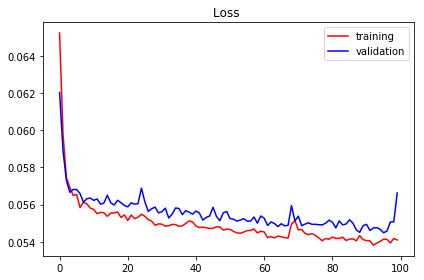

In [129]:
plt.title("Loss ")
plt.plot(history_lstm_pre_gl.history["loss"], color="r", label="training")
plt.plot(history_lstm_pre_gl.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

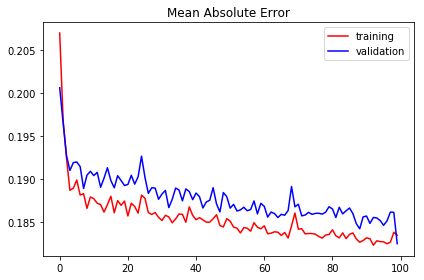

In [130]:
plt.title("Mean Absolute Error")
plt.plot(history_lstm_pre_gl.history["mean_absolute_error"], color="r", label="training")
plt.plot(history_lstm_pre_gl.history["val_mean_absolute_error"], color="b", label="validation")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [114]:
def create_lstm_pre():
    itext = Input(shape=(MAX_LEN,))
    embed = Embedding(VOCAB_SIZE+1, 100, 
                      embeddings_initializer=Constant(g_word_embedding_matrix),
                      input_length=MAX_LEN, trainable=False)(itext)
    lstm = LSTM(MAX_LEN, dropout=0.3, recurrent_dropout=0.3)(embed)

    drop = Dropout(0.6)(lstm)
    dens = Dense(1)(drop)
    acti = Activation('sigmoid')(dens)
    
    model = Model([itext], acti)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

model_lstm_pre = create_lstm_pre()
model_lstm_pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 400, 100)          500100    
_________________________________________________________________
lstm_4 (LSTM)                (None, 400)               801600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 401       
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 1,302,101
Trainable params: 802,001
Non-trainable params: 500,100
______________________________________________________________

In [115]:
history_lstm_pre = model_lstm_pre.fit([padded_docs_train], 
                                            y_train,
                                            batch_size=2048, epochs=100, 
                                            validation_split=.2, verbose=1, shuffle=True)

Train on 8304 samples, validate on 2077 samples
Epoch 1/100
8304/8304 [==============================] - 100s 12ms/step - loss: 0.0654 - mean_absolute_error: 0.2063 - val_loss: 0.0637 - val_mean_absolute_error: 0.2042
Epoch 2/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0602 - mean_absolute_error: 0.1973 - val_loss: 0.0599 - val_mean_absolute_error: 0.1978
Epoch 3/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0577 - mean_absolute_error: 0.1930 - val_loss: 0.0579 - val_mean_absolute_error: 0.1947
Epoch 4/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0565 - mean_absolute_error: 0.1902 - val_loss: 0.0559 - val_mean_absolute_error: 0.1895
Epoch 5/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0560 - mean_absolute_error: 0.1888 - val_loss: 0.0564 - val_mean_absolute_error: 0.1916
Epoch 6/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0556 - mean_absolute_erro

Epoch 49/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0547 - mean_absolute_error: 0.1844 - val_loss: 0.0554 - val_mean_absolute_error: 0.1869
Epoch 50/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0547 - mean_absolute_error: 0.1845 - val_loss: 0.0559 - val_mean_absolute_error: 0.1885
Epoch 51/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0550 - mean_absolute_error: 0.1854 - val_loss: 0.0555 - val_mean_absolute_error: 0.1874
Epoch 52/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0548 - mean_absolute_error: 0.1851 - val_loss: 0.0552 - val_mean_absolute_error: 0.1864
Epoch 53/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0549 - mean_absolute_error: 0.1835 - val_loss: 0.0552 - val_mean_absolute_error: 0.1861
Epoch 54/100
8304/8304 [==============================] - 97s 12ms/step - loss: 0.0547 - mean_absolute_error: 0.1847 - val_loss: 0.0559 - val_mean_abs

In [116]:
# saving
with open('./model/history_lstm_pre.pickle', 'wb') as handle:
    pickle.dump(history_lstm_pre.history, handle)
    
model_lstm_pre.save_weights('./model/checkpoint_{}.hdf5'.format(
    'lstm_pre_100'))

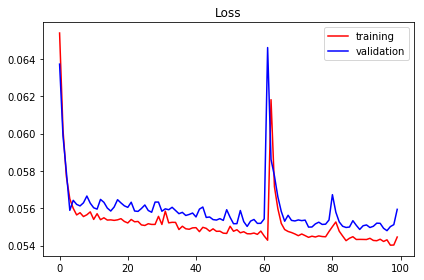

In [117]:
plt.title("Loss")
plt.plot(history_lstm_pre.history["loss"], color="r", label="training")
plt.plot(history_lstm_pre.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [118]:
def create_lstm_gl():
    itext = Input(shape=(MAX_LEN,))
    embed = Embedding(VOCAB_SIZE+1, 100, 
                      input_length=MAX_LEN, mask_zero=True)(itext)
    lstm = LSTM(MAX_LEN, dropout=0.3, recurrent_dropout=0.3)(embed)
    
    igl = Input(shape=(4,))
    
    conc = concatenate([lstm, igl])
    
    drop = Dropout(0.6)(lstm)
    dens = Dense(1)(drop)
    acti = Activation('sigmoid')(dens)
    
    model = Model([itext, igl], acti)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

model_lstm_gl = create_lstm_gl()
model_lstm_gl.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 400, 100)          500100    
_________________________________________________________________
lstm_5 (LSTM)                (None, 400)               801600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 401       
_________________________________________________________________
activation_5 (Activation)    (None, 1)                 0         
Total params: 1,302,101
Trainable params: 1,302,101
Non-trainable params: 0
_________________________________________________________________


In [119]:
history_lstm_gl = model_lstm_gl.fit([padded_docs_train, gl_train], 
                                            y_train,
                                            batch_size=2048, epochs=100, 
                                            validation_split=.2, verbose=1, shuffle=True)

Train on 8304 samples, validate on 2077 samples
Epoch 1/100
8304/8304 [==============================] - 128s 15ms/step - loss: 0.0647 - mean_absolute_error: 0.2070 - val_loss: 0.0571 - val_mean_absolute_error: 0.1865
Epoch 2/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0577 - mean_absolute_error: 0.1921 - val_loss: 0.0588 - val_mean_absolute_error: 0.1990
Epoch 3/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0567 - mean_absolute_error: 0.1933 - val_loss: 0.0548 - val_mean_absolute_error: 0.1874
Epoch 4/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0543 - mean_absolute_error: 0.1836 - val_loss: 0.0536 - val_mean_absolute_error: 0.1846
Epoch 5/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0522 - mean_absolute_error: 0.1803 - val_loss: 0.0517 - val_mean_absolute_error: 0.1817
Epoch 6/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0486 - mean_absolute

Epoch 49/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0189 - mean_absolute_error: 0.1079 - val_loss: 0.0509 - val_mean_absolute_error: 0.1783
Epoch 50/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0194 - mean_absolute_error: 0.1102 - val_loss: 0.0471 - val_mean_absolute_error: 0.1710
Epoch 51/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0184 - mean_absolute_error: 0.1063 - val_loss: 0.0499 - val_mean_absolute_error: 0.1762
Epoch 52/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0180 - mean_absolute_error: 0.1056 - val_loss: 0.0482 - val_mean_absolute_error: 0.1733
Epoch 53/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0179 - mean_absolute_error: 0.1055 - val_loss: 0.0493 - val_mean_absolute_error: 0.1749
Epoch 54/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0178 - mean_absolute_error: 0.1053 - val_loss: 0.0495 - val_me

Epoch 97/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0112 - mean_absolute_error: 0.0821 - val_loss: 0.0531 - val_mean_absolute_error: 0.1810
Epoch 98/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0113 - mean_absolute_error: 0.0826 - val_loss: 0.0563 - val_mean_absolute_error: 0.1858
Epoch 99/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0112 - mean_absolute_error: 0.0831 - val_loss: 0.0546 - val_mean_absolute_error: 0.1834
Epoch 100/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0111 - mean_absolute_error: 0.0818 - val_loss: 0.0563 - val_mean_absolute_error: 0.1860


In [120]:
# saving
with open('./model/history_lstm_gl.pickle', 'wb') as handle:
    pickle.dump(history_lstm_gl.history, handle)
    
model_lstm_gl.save_weights('./model/checkpoint_{}.hdf5'.format(
    'lstm_gl_100'))


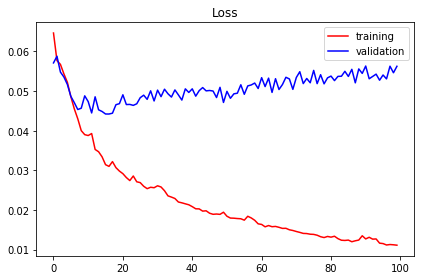

In [121]:
plt.title("Loss")
plt.plot(history_lstm_gl.history["loss"], color="r", label="training")
plt.plot(history_lstm_gl.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [122]:
def create_lstm():
    itext = Input(shape=(MAX_LEN,))
    embed = Embedding(VOCAB_SIZE+1, 100, 
                      input_length=MAX_LEN, mask_zero=True)(itext)
    lstm = LSTM(MAX_LEN, dropout=0.3, recurrent_dropout=0.3)(embed)
    
    drop = Dropout(0.6)(lstm)
    dens = Dense(1)(drop)
    acti = Activation('sigmoid')(dens)
    
    model = Model([itext], acti)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

model_lstm = create_lstm()
model_lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 400)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 400, 100)          500100    
_________________________________________________________________
lstm_6 (LSTM)                (None, 400)               801600    
_________________________________________________________________
dropout_6 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
_________________________________________________________________
activation_6 (Activation)    (None, 1)                 0         
Total params: 1,302,101
Trainable params: 1,302,101
Non-trainable params: 0
_________________________________________________________________


In [123]:
history_lstm = model_lstm.fit([padded_docs_train], 
                                            y_train,
                                            batch_size=2048, epochs=100, 
                                            validation_split=.2, verbose=1, shuffle=True)

Train on 8304 samples, validate on 2077 samples
Epoch 1/100
8304/8304 [==============================] - 126s 15ms/step - loss: 0.0645 - mean_absolute_error: 0.2067 - val_loss: 0.0556 - val_mean_absolute_error: 0.1891
Epoch 2/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0560 - mean_absolute_error: 0.1883 - val_loss: 0.0547 - val_mean_absolute_error: 0.1856
Epoch 3/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0549 - mean_absolute_error: 0.1861 - val_loss: 0.0541 - val_mean_absolute_error: 0.1886
Epoch 4/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0524 - mean_absolute_error: 0.1818 - val_loss: 0.0490 - val_mean_absolute_error: 0.1766
Epoch 5/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0487 - mean_absolute_error: 0.1752 - val_loss: 0.0504 - val_mean_absolute_error: 0.1808
Epoch 6/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0463 - mean_absolute

Epoch 49/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0182 - mean_absolute_error: 0.1051 - val_loss: 0.0500 - val_mean_absolute_error: 0.1759
Epoch 50/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0183 - mean_absolute_error: 0.1065 - val_loss: 0.0497 - val_mean_absolute_error: 0.1749
Epoch 51/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0181 - mean_absolute_error: 0.1060 - val_loss: 0.0508 - val_mean_absolute_error: 0.1767
Epoch 52/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0181 - mean_absolute_error: 0.1057 - val_loss: 0.0503 - val_mean_absolute_error: 0.1767
Epoch 53/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0183 - mean_absolute_error: 0.1069 - val_loss: 0.0533 - val_mean_absolute_error: 0.1816
Epoch 54/100
8304/8304 [==============================] - 124s 15ms/step - loss: 0.0176 - mean_absolute_error: 0.1042 - val_loss: 0.0509 - val_me

Epoch 97/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0120 - mean_absolute_error: 0.0858 - val_loss: 0.0566 - val_mean_absolute_error: 0.1871
Epoch 98/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0123 - mean_absolute_error: 0.0861 - val_loss: 0.0567 - val_mean_absolute_error: 0.1868
Epoch 99/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0117 - mean_absolute_error: 0.0842 - val_loss: 0.0557 - val_mean_absolute_error: 0.1848
Epoch 100/100
8304/8304 [==============================] - 123s 15ms/step - loss: 0.0115 - mean_absolute_error: 0.0829 - val_loss: 0.0578 - val_mean_absolute_error: 0.1877


In [124]:
# saving
with open('./model/history_lstm.pickle', 'wb') as handle:
    pickle.dump(history_lstm.history, handle)
    
model_lstm.save_weights('./model/checkpoint_{}.hdf5'.format(
    'lstm_100'))


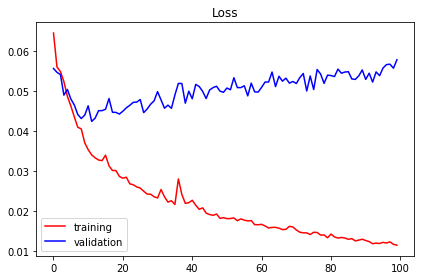

In [125]:
plt.title("Loss")
plt.plot(history_lstm.history["loss"], color="r", label="training")
plt.plot(history_lstm.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------------

In [53]:
model.save_weights('./model/checkpoint_epoch_{}.hdf5'.format('unilstm_adam_acc_100'))

In [54]:
model.load_weights('./model/checkpoint_epoch_{}.hdf5'.format('unilstm_adam_acc_100'))

In [55]:
model.predict(X_concat[:1])

array([[0.40976614]], dtype=float32)

In [58]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 13.13%
